In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

2023-11-26 11:32:46.597690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-26 11:32:46.724434: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-26 11:32:46.724471: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-26 11:32:46.742890: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 11:32:47.558736: W tensorflow/stream_executor/platform/de

In [ ]:
# Load and preprocess the data
data = yf.download("^GSPC", start="2000-01-01", end="2023-11-01")
data.index = data.index.date
close_prices = data['Close'].values.reshape(-1, 1)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(close_prices)

In [ ]:
# Prepare training data
look_back = 250  # Number of previous days to use for prediction
X_train, y_train = [], []
for i in range(look_back, len(scaled_prices)):
    X_train.append(scaled_prices[i-look_back:i, 0])
    y_train.append(scaled_prices[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape input data for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# Model specifiaction

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')

2023-11-25 15:42:36.605232: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-11-25 15:42:36.605265: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-25 15:42:36.605281: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-0b986107-e036-494e-b644-ef8c9f84d281): /proc/driver/nvidia/version does not exist
2023-11-25 15:42:36.605537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
180/180 [==============================] - 85s 452ms/step - loss: 0.0061
Epoch 2/50
180/180 [==============================] - 82s 456ms/step - loss: 0.0017
Epoch 3/50
180/180 [==============================] - 82s 457ms/step - loss: 0.0017
Epoch 4/50
180/180 [==============================] - 82s 458ms/step - loss: 0.0015
Epoch 5/50
180/180 [==============================] - 82s 458ms/step - loss: 0.0013
Epoch 6/50
180/180 [==============================] - 83s 461ms/step - loss: 0.0012
Epoch 7/50
180/180 [==============================] - 83s 463ms/step - loss: 0.0010
Epoch 8/50
180/180 [==============================] - 83s 459ms/step - loss: 0.0011
Epoch 9/50
180/180 [==============================] - 83s 462ms/step - loss: 0.0010
Epoch 10/50
180/180 [==============================] - 83s 464ms/step - loss: 0.0011
Epoch 11/50
180/180 [==============================] - 83s 462ms/step - loss: 9.9924e-04
Epoch 12/50
180/180 [==============================] - 84s 466ms/step 

In [ ]:
# Step 3: Make predictions for the future 30 days
look_back_days = close_prices[-look_back:].reshape(1, -1)
scaled_predictions = []
for _ in range(30):
    scaled_prediction = model.predict(look_back_days)
    scaled_predictions.append(scaled_prediction[0, 0])
    look_back_days = np.append(look_back_days[:, 1:], scaled_prediction, axis=1)

# Inverse transform the predictions to get actual values
predictions = scaler.inverse_transform(np.array(scaled_predictions).reshape(-1, 1))

1/1 [==============================] - 0s 33ms/step


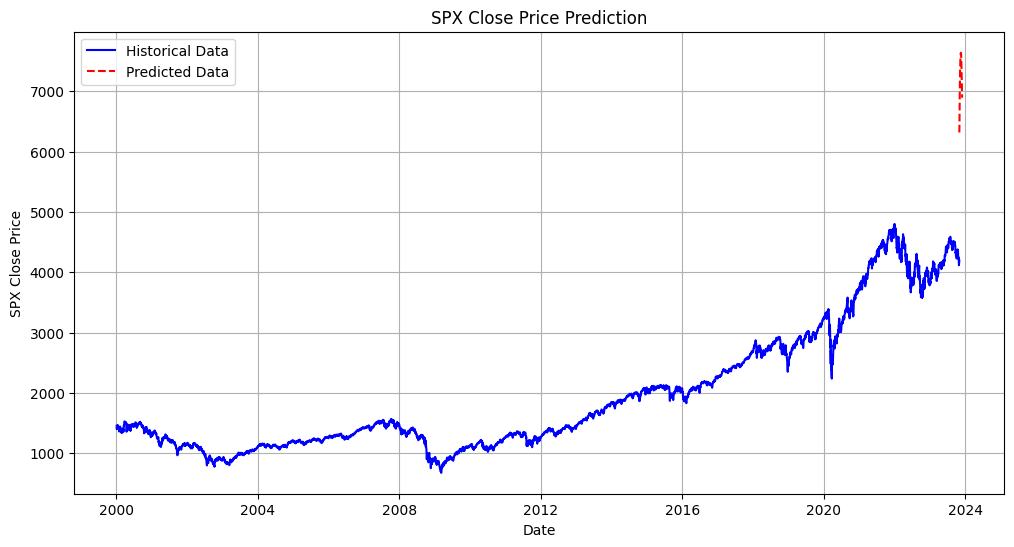

In [ ]:
# Step 4: Plot historical data and predicted data
plt.figure(figsize=(12, 6))
plt.plot(data.index, close_prices, color='blue', label='Historical Data')
plt.plot(pd.date_range(start=data.index[-1], periods=30, freq='D'), predictions, color='red', linestyle='dashed',
         label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('SPX Close Price')
plt.title('SPX Close Price Prediction')
plt.legend()
plt.grid(True)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0b986107-e036-494e-b644-ef8c9f84d281' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>